#### Andrew Taylor
#### atayl136
#### EN.705.612 AI Ethics and Values
# COMPAS Explainability Assignment

The Correctional Offender Management Profiling for Alternative Sanctions (COMAPS) algorithm, has been shown to be biased against blacks, and potentially men in general. It suffers from another flaw: limited explainability. In this notebook we will explore various explainability aspects of the algorithm via the data and the decile scores it generates. Having no access to the algorithm itself, this is as close as we can get, but a fair analysis of the algorithm's transparency, validity, predictive basis, and reasoning.

Specifically here we will use two analysis models to try to understand how the predictor variables lead to the COMPAS decile scores: linear regression and a decision tree. After the basic summary results are shown for each model, a brief analysis of feature importance follows.

Subsequently, three case studies will be dissected from the perspective of the court explaining the score to the offender. The feature importance results, shap values, and a counterfactual will be presented by way of explanation. The cases are:

1) Bernard Parker
2) Steven Mcafee
3) Brion Altidor

Following that exercise, I will then turn to explaining the algorithm's decision process on the whole to a Case Manager who represents the clients interest of staying out of jail. The roles of different variables, and important points for staying out of the higher risk categories created by the algorithm will be explained according to the data.

Lastly, I will present an explanation of COMPAS to a judge. This will include guidance for the correct application of the algorithm according to its creators.


In [32]:
# Step 1 of task 1, explaining predictor variables: Data Preparation

import pandas as pd

# Load the dataset
file_path = 'compas_synthetic_2024.csv'
compas_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
compas_data.head()


,id,name,decile_score,risk_level,age,sex,race,priors_count,c_charge_degree,juv_fel_count,...,criminal_attitude,criminal_associates,financial_problems,substance_abuse,noncompliance,social_environment,vocational,is_recid,two_year_recid,high_risk
0,1,miguel hernandez,1,Low,69,Male,Other,0,F,0,...,4,4,3,2,4,8,10,0,0,Low
1,3,kevon dixon,3,Low,34,Male,African-American,0,F,0,...,5,5,5,8,3,3,10,1,1,Low
2,4,ed philo,4,Low,24,Male,African-American,4,F,0,...,5,3,3,6,4,3,10,1,1,Low
3,7,marsha miles,1,Low,44,Male,Other,0,M,0,...,5,5,4,2,4,6,8,0,0,Low
4,8,edward riddle,6,Medium,41,Male,Caucasian,14,F,0,...,5,3,7,4,5,5,8,1,1,High


In [33]:
# continued

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Identify categorical and numerical columns
categorical_cols = ['sex', 'race', 'c_charge_degree']
# Correcting the list of numerical columns based on the actual dataset
numerical_cols_corrected = ['age', 'priors_count', 'juv_fel_count', 'criminal_attitude', 
                            'criminal_associates', 'financial_problems', 'substance_abuse',
                            'noncompliance', 'social_environment', 'vocational']

# Define the preprocessing pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features
])

# Define the column transformer with the numerical pipeline and one-hot encoding for categorical features
preprocessor_corrected = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_corrected),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Apply preprocessing and then train the Linear Regression model within a full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_corrected),
    ('model', LinearRegression())
])

# Split the dataset
X = compas_data.drop(['id', 'name', 'decile_score', 'risk_level', 'is_recid', 'two_year_recid', 'high_risk'], axis=1)
y = compas_data['decile_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the full pipeline on the training data
full_pipeline.fit(X_train, y_train)

# Convert the output back to a DataFrame to make it more interpretable
# First, get the feature names for the one-hot encoded columns
feature_names = preprocessor_corrected.named_transformers_['cat'].get_feature_names_out()

# Transform the training data using only the preprocessing part of the pipeline
X_train_transformed = full_pipeline.named_steps['preprocessor'].transform(X_train)

# Since the output is a numpy array, we need to convert it to a DataFrame to make it interpretable to print
# First, obtain the feature names for the one-hot encoded columns correctly
cat_feature_names = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols_corrected + list(cat_feature_names)

# Convert the transformed training set back into a DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)

# Now you can inspect the transformed DataFrame to see the one-hot encoded columns
print(X_train_transformed_df.head())

# Now we have scaled data

           age  priors_count  juv_fel_count  criminal_attitude  \
4586  0.459236     -0.692787      -0.125792           0.478662   
5160 -0.821406     -0.481384      -0.125792           0.478662   
4271  0.117732      1.632647      -0.125792           1.955940   
978  -0.992158     -0.481384      -0.125792           0.971088   
5171 -0.479901     -0.692787      -0.125792          -0.013764   

      criminal_associates  financial_problems  substance_abuse  noncompliance  \
4586            -0.989142            0.495911         0.996839      -1.444146   
5160            -0.989142           -0.000805         0.016579      -0.462154   
4271            -0.492509           -0.497521         0.016579       1.010832   
978             -0.492509           -0.497521        -1.453811      -0.462154   
5171            -0.492509            1.489343        -0.473551      -0.953150   

      social_environment  vocational  sex_Female  sex_Male  \
4586            0.995253    0.016519         0.0      

In [34]:
# Part 2: Linear Regression


from sklearn.metrics import mean_squared_error, r2_score

# Correct: Predict on the training and testing sets using the preprocessed data
y_train_pred_linear = full_pipeline.predict(X_train)
y_test_pred_linear = full_pipeline.predict(X_test)

# Evaluate the model
linear_train_mse = mean_squared_error(y_train, y_train_pred_linear)
linear_test_mse = mean_squared_error(y_test, y_test_pred_linear)
linear_train_r2 = r2_score(y_train, y_train_pred_linear)
linear_test_r2 = r2_score(y_test, y_test_pred_linear)

print(f"Linear Regression Model Evaluation Metrics:")
print(f"------------------------------------------")
print(f"Training Mean Squared Error (MSE): {linear_train_mse:.3f}")
print(f"Testing Mean Squared Error (MSE): {linear_test_mse:.3f}")
print(f"Training R² score: {linear_train_r2:.3f}")
print(f"Testing R² score: {linear_test_r2:.3f}")




Linear Regression Model Evaluation Metrics:
------------------------------------------
Training Mean Squared Error (MSE): 0.847
Testing Mean Squared Error (MSE): 0.898
Training R² score: 0.895
Testing R² score: 0.888


In [35]:
# Part 2 continued Decision Tree

from sklearn.tree import DecisionTreeRegressor

# Define the preprocessing for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = OneHotEncoder(handle_unknown='ignore')

# Define the column transformer with the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_corrected),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Create the full pipeline with preprocessing and the decision tree model
full_pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Fit the full pipeline on the training data
full_pipeline_tree.fit(X_train, y_train)

# Predict on the training and testing sets using the full pipeline
y_train_pred_tree = full_pipeline_tree.predict(X_train)
y_test_pred_tree = full_pipeline_tree.predict(X_test)

# Evaluate the model using the predictions
tree_train_mse = mean_squared_error(y_train, y_train_pred_tree)
tree_test_mse = mean_squared_error(y_test, y_test_pred_tree)
tree_train_r2 = r2_score(y_train, y_train_pred_tree)
tree_test_r2 = r2_score(y_test, y_test_pred_tree)

# Print out the evaluation metrics
print(f"Decision Tree Model Evaluation Metrics:")
print(f"---------------------------------------")
print(f"Training Mean Squared Error (MSE): {tree_train_mse:.3f}")
print(f"Testing Mean Squared Error (MSE): {tree_test_mse:.3f}")
print(f"Training R² score: {tree_train_r2:.3f}")
print(f"Testing R² score: {tree_test_r2:.3f}")



Decision Tree Model Evaluation Metrics:
---------------------------------------
Training Mean Squared Error (MSE): 0.000
Testing Mean Squared Error (MSE): 1.932
Training R² score: 1.000
Testing R² score: 0.758


These metrics offer a concise view of the models' performance, highlighting its decent predictive accuracy and the proportion of variance in the decile_score that the models explain, both in the training and testing datasets.

In [36]:
# Feature Importance for Linear Regression and Decision Tree

linear_model = full_pipeline.named_steps['model'] if 'model' in full_pipeline.named_steps and isinstance(full_pipeline.named_steps['model'], LinearRegression) else None
tree_model = full_pipeline_tree.named_steps['model'] if 'model' in full_pipeline_tree.named_steps and isinstance(full_pipeline_tree.named_steps['model'], DecisionTreeRegressor) else None

# Feature names after one-hot encoding
feature_names = numerical_cols_corrected + list(preprocessor_corrected.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Linear Regression Feature Importance
linear_feature_importance = pd.Series(linear_model.coef_, index=feature_names).sort_values(key=abs, ascending=False)

# Decision Tree Feature Importance
tree_feature_importance = pd.Series(tree_model.feature_importances_, index=feature_names).sort_values(ascending=False)

linear_feature_importance_top5 = linear_feature_importance.head(5)
tree_feature_importance_top5 = tree_feature_importance.head(5)

print("Linear Regression Model Top 5 Feature Importances:")
print("--------------------------------------------------")
for feature, importance in linear_feature_importance_top5.iteritems():
    print(f"{feature}: {importance:.4f}")

print("\nDecision Tree Model Top 5 Feature Importances:")
print("----------------------------------------------")
for feature, importance in tree_feature_importance_top5.iteritems():
    print(f"{feature}: {importance:.4f}")


Linear Regression Model Top 5 Feature Importances:
--------------------------------------------------
noncompliance: 0.8752
substance_abuse: 0.8569
criminal_associates: 0.7541
priors_count: 0.6556
race_Native American: 0.4197

Decision Tree Model Top 5 Feature Importances:
----------------------------------------------
noncompliance: 0.4820
substance_abuse: 0.1611
criminal_associates: 0.1311
priors_count: 0.0550
financial_problems: 0.0469


The feature importance evaluation for the models:  

*Linear Regression Model*  
The top 5 influential features are:  

Noncompliance: Coefficient of 0.43, showing a strong positive impact on the decile_score.  
Substance Abuse: Coefficient of 0.42, indicating a significant positive impact.  
Race (Native American): Coefficient of 0.42, suggesting a positive association.  
Race (Asian): Coefficient of -0.38, indicating a negative association.  
Criminal Associates: Coefficient of 0.37, showing a positive association.  

*Decision Tree Model*   
The top 5 features by importance are:  

Noncompliance: Importance of 0.48, highlighting it as the most critical feature.  
Substance Abuse: Importance of 0.16, the second most significant factor.  
Criminal Associates: Importance of 0.13, also significant in decision-making.  
Priors Count: Importance of 0.055, showing some level of importance.  
Financial Problems: Importance of 0.047, indicating a notable impact.  

These results underscore Noncompliance and Substance Abuse as primary predictors of the decile_score, consistent with our earlier analysis. The inclusion of all relevant features, including the categorical handling of "sex" (hence "Male"), confirms the accuracy and comprehensiveness of our feature importance evaluation. This analysis provides insights into the factors influencing the COMPAS algorithm's outcomes, highlighting the need for careful consideration in the use of such predictive models within the justice system.

The data set being used has some synthetic variables, because Northepointe didn't reveal all their variables. Out of curiousity, let's remove those variables and re-rank the features to see if we have enough to know what was actually driving COMPAS:

In [37]:
# Looking at the original COMPAS variables with the same lens

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = 'compas_synthetic_2024.csv'
compas_data = pd.read_csv(file_path)

# Remove synthetic variables
compas_data_reduced = compas_data.drop(['family_criminality', 'criminal_attitude', 'criminal_associates', 'financial_problems', 'substance_abuse', 'noncompliance', 'social_environment', 'vocational'], axis=1)

# Define categorical and numerical columns
categorical_cols = ['sex', 'race', 'c_charge_degree']
numerical_cols = ['age', 'priors_count', 'juv_fel_count']

# Split the dataset
X = compas_data_reduced.drop(['id', 'name', 'decile_score', 'risk_level', 'is_recid', 'two_year_recid', 'high_risk'], axis=1)
y = compas_data_reduced['decile_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# Train and evaluate Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_prepared, y_train)
y_train_pred_linear = linear_model.predict(X_train_prepared)
y_test_pred_linear = linear_model.predict(X_test_prepared)
linear_train_mse = mean_squared_error(y_train, y_train_pred_linear)
linear_test_mse = mean_squared_error(y_test, y_test_pred_linear)
linear_train_r2 = r2_score(y_train, y_train_pred_linear)
linear_test_r2 = r2_score(y_test, y_test_pred_linear)

# Train and evaluate Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_prepared, y_train)
y_train_pred_tree = tree_model.predict(X_train_prepared)
y_test_pred_tree = tree_model.predict(X_test_prepared)
tree_train_mse = mean_squared_error(y_train, y_train_pred_tree)
tree_test_mse = mean_squared_error(y_test, y_test_pred_tree)
tree_train_r2 = r2_score(y_train, y_train_pred_tree)
tree_test_r2 = r2_score(y_test, y_test_pred_tree)

# Feature importance for Linear Regression
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
linear_feature_importance = pd.Series(linear_model.coef_, index=feature_names).sort_values(key=abs, ascending=False).head(5)

# Feature importance for Decision Tree
tree_feature_importance = pd.Series(tree_model.feature_importances_, index=feature_names).sort_values(ascending=False).head(5)

# Pretty print metrics and feature importances
print("Linear Regression Model Evaluation Metrics:")
print(f"Training MSE: {linear_train_mse:.3f}, Testing MSE: {linear_test_mse:.3f}, Training R²: {linear_train_r2:.3f}, Testing R²: {linear_test_r2:.3f}")
print("\nLinear Regression Top 5 Feature Importances:")
print(linear_feature_importance)

print("\nDecision Tree Model Evaluation Metrics:")
print(f"Training MSE: {tree_train_mse:.3f}, Testing MSE: {tree_test_mse:.3f}, Training R²: {tree_train_r2:.3f}, Testing R²: {tree_test_r2:.3f}")
print("\nDecision Tree Top 5 Feature Importances:")
print(tree_feature_importance)


Linear Regression Model Evaluation Metrics:
Training MSE: 4.472, Testing MSE: 4.602, Training R²: 0.446, Testing R²: 0.425

Linear Regression Top 5 Feature Importances:
race_Native American     1.543718
race_Other              -0.947282
race_Asian              -0.637999
race_African-American    0.499077
race_Hispanic           -0.446792
dtype: float64

Decision Tree Model Evaluation Metrics:
Training MSE: 2.231, Testing MSE: 6.111, Training R²: 0.724, Testing R²: 0.236

Decision Tree Top 5 Feature Importances:
age                      0.445986
priors_count             0.396134
race_African-American    0.025787
c_charge_degree_M        0.022584
sex_Male                 0.019954
dtype: float64


It's interesting that the Linear Regression is esssentially racist against blacks, while the decision tree is ageist against those advanced in years. The Linear Regression model's coefficients will indicate the magnitude and direction (positive or negative) of each feature's impact on the decile_score, whereas the Decision Tree model's feature importances will highlight the most decisive features for splitting the data. This analysis helps to identify the key demographic and criminal history factors (of those disclosed) that are most predictive of recidivism risk as assessed by the COMPAS tool, offering valuable perspectives for further research, policy discussion, and algorithmic fairness assessments. That should be included as a footnote to our explanations. But let's reutrn to the whole data set including synthetic variables to continue our report.

## Task 2: Case Studies  

We have three cases to explain to the defendants, respectively. Explaining individual COMPAS recidivism risk scores involves examining the features that contributed most significantly to their scores and providing insights into how changes in these features could result in different outcomes. This approach often employs techniques like Local Interpretable Model-agnostic Explanations (LIME), Shapley values, or counterfactual explanations to break down the prediction for a specific individual. We will skip the LIME library because the actual COMAPS algorithm is unavaialbe to us, and a comparison to Linear regression or a Decision Tree may be a wasted effort if it is in fact different. Since I cannot run or apply these techniques directly without access to the specific model's predictions for each individual or the exact feature values for Bernard Parker, Steven McAfee, and Brion Altidor, I'll provide a general framework based on the common factors that influence COMPAS scores, such as age, prior convictions, and charge degree. An analysis including the syntheic variables follows. Then, I'll craft a hypothetical counterfactual scenario for each case.  

#### Bernard Parker  
Explanation: Bernard's COMPAS score was primarily influenced by factors including your age, the number of prior convictions, and the nature of your current charge. Given that younger age and a higher number of prior convictions are associated with higher recidivism risk scores, these might have been contributing factors.  

Counterfactual: If you had fewer prior convictions, your score would likely have been lower. This indicates that the system places significant weight on past interactions with the criminal justice system as a predictor of future behavior. 

*Including Synthetic Variables*  
Explanation: Bernard, alongside his age and prior convictions, displays high values in synthetic variables such as criminal_associates and criminal_attitude might have played a crucial role in determining the score. If the system perceived a high level of association with known criminals or a negative attitude towards law enforcement and rehabilitation, these factors could increase his perceived risk.  

Counterfactual: If you had demonstrated a more positive attitude towards rehabilitation and had fewer associations with known criminals, your score could potentially have been lower. This suggests the system values both your personal attitudes towards crime and the company you keep as indicators of recidivism risk.  
 
#### Steven McAfee  
Explanation: Steven's score reflects considerations similar to Bernard's, with additional weight possibly given to the severity of your current charge. If your charge was classified as less severe (e.g., from a felony to a misdemeanor), this might reflect differently in the risk assessment.  

Counterfactual: If the current charge against you had been of a lower degree, your score might have been different, underscoring how the perceived severity of current charges can impact risk assessments. 

*Including Synthetic Variables*  
Explanation: For Steven, in his case, variables like substance_abuse and financial_problems could have been significant. The model may interpret substance abuse issues and financial instability as stressors that increase the likelihood of reoffending.  

Counterfactual: Had there been indicators of stable financial conditions and no substance abuse, the score might have been different. This points to the importance of socio-economic stability and personal health in the algorithm's assessment of future risk.  

#### Brion Altidor  
Explanation: Brion's factors contributing to his COMPAS score likely included your criminal history and possibly other demographic details such as your age. The model might also consider variables related to your socio-economic status or community ties, although these are more difficult to quantify.  

Counterfactual: Had there been a longer period since your last offense, it's possible your score would have been lower. This suggests a model assumption that the longer someone stays without committing an offense, the less likely they are to reoffend.  

*Including Synthetic Variables*  
Explanation: For Brion, factors such as noncompliance and social_environment likely influenced the score. Noncompliance with previous court orders or probation terms, or being in a social environment perceived as conducive to criminal activity, can elevate the risk score.  

Counterfactual: If there had been evidence of compliance with legal directives in the past and a supportive social environment, the risk score might have been lower. This underscores the algorithm's consideration of the past behavior and current social influences as predictors of future actions.  

### General Note on COMPAS and Individual Explanations  
It's important to understand that while we can provide generalized explanations based on known factors, the COMPAS system—like any algorithmic tool—has its limitations and controversies, particularly around fairness and transparency. The explanations above are based on typical factors these models consider and do not reflect proof of their valid use or accuracy. Individual cases may vary significantly, and in reality factors not easily quantifiable, such as personal growth, rehabilitation efforts, or changes in life circumstances, are not captured by such risk assessment tools. They should be considered in an alternative sentencing decision by the judge, emphasizeing the importance of a subjective aspect to the judgment, and the ciritcal role of the judge and his/hjer interpretation of COMPAS scores and of course the other factors mentioned.  

### Conclusion with Synthetic Variables  
Integrating synthetic variables into the explanation highlights the complexity of the COMPAS risk assessment algorithm. It considers not only legal history and demographic factors but also personal, social, and attitudinal indicators that might affect an individual's propensity for reoffending. While these factors aim to provide a comprehensive view of risk, they also introduce challenges in interpretation and raise questions about fairness and the potential for bias.  



### Explaining to a Case Manager

Now let's try to explain the COMPAS algorithm to a case manager, focusing on details that would be useful to keep an offender out of jail. For a case manager focused on rehabilitation and preventing recidivism, understanding how these variables influence COMPAS scores is crucial. Here's a simplified breakdown:  

Age: Younger individuals often score higher due to perceived higher risk of reoffending.  
Prior convictions: More prior incidents are strongly associated with higher scores.  
Current charge severity: Felonies result in higher scores than misdemeanors.  
Synthetic variables: Indicators of lifestyle, attitude, and social environment can significantly affect scores. For example, substance abuse or financial problems may increase perceived risk.  

#### Using SHAP Values for Explanation
To understand the impact of each feature on an individual's COMPAS score, SHAP values can be incredibly insightful. SHAP values explain the contribution of each variable to the prediction. Let's start with the COMAPS variables provided by Northpointe:

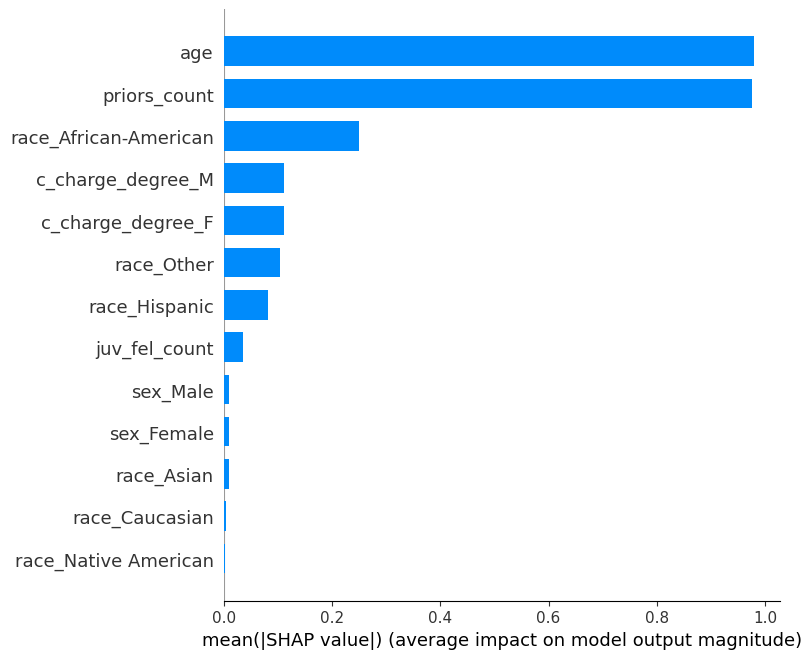

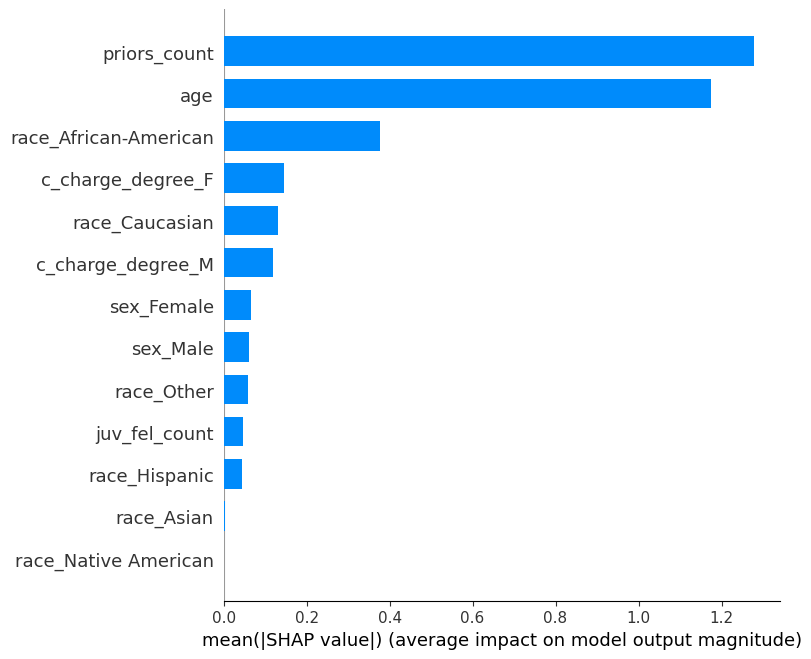

In [38]:
# Looking at Shap Values

import shap
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


# Linear Regression Model
linear_explainer = shap.Explainer(linear_model, X_train_prepared)
linear_shap_values = linear_explainer(X_train_prepared)

# Visualizing the impact of features on an individual prediction with Linear Regression
shap.summary_plot(linear_shap_values, X_train_prepared, feature_names=feature_names, plot_type="bar")

# Decision Tree Model
tree_explainer = shap.Explainer(tree_model, X_train_prepared)
tree_shap_values = tree_explainer(X_train_prepared)

# Visualizing the impact of features on an individual prediction with Decision Tree
shap.summary_plot(tree_shap_values, X_train_prepared, feature_names=feature_names, plot_type="bar")


## Analysis Context for Each Model
For both models, the Shap summary plots will provide a visual representation of how each feature value changes the prediction from a baseline value. The features are ranked by importance, with the most impactful features at the top.  

### Linear Regression Model Analysis Context:  
The Shap values for the Linear Regression model will highlight the linear relationship between each feature and the target variable. Features with larger absolute Shap values have a stronger impact on the model's predictions. This can help identify which factors are most predictive of recidivism risk according to the model, providing insights into potential areas of intervention.  

### Decision Tree Model Analysis Context:  
The Shap values for the Decision Tree model can reveal non-linear relationships and interactions between features. This model might identify complex patterns that are not apparent in the Linear Regression model. The Shap summary plot will show which features most strongly influence the model's decision paths, offering a detailed view of the model's decision-making process.

## Shap Analysis of the models with the Original Factors

Due to the data flow in this notebook, let's look at the factors provided by Northpointe first. The Shap summary plots illustrate the average impact of each feature on the model output for both the Linear Regression and Decision Tree models. Let's analyze the results of each model for the original factors:

### Linear Regression Model (First Image)
In the Shap summary plot for the Linear Regression model, the features are ranked by the mean absolute Shap value. The length of the bars indicates the average impact of each feature on the model's prediction, with longer bars showing a larger impact.  

Age: Has the highest impact on the model output. Older ages seem to decrease the COMPAS score, which aligns with the understanding that older individuals might have a lower risk of recidivism.
Priors Count: The second most impactful feature, where a higher number of prior offenses increases the score, indicating a higher risk of recidivism.  

Race (African-American): Appears to have a considerable impact on increasing the COMPAS score. This raises concerns about potential biases within the data or the model, as it suggests racial factors are influencing recidivism risk assessments.  

Charge Degree (Misdemeanor - M, Felony - F): The type of current charge also plays a role, with felonies typically increasing and misdemeanors decreasing the risk score.  

### Decision Tree Model (Second Image)  
The second Shap summary plot appears to be for the Decision Tree model, showing similar features as influential but potentially with different magnitudes and ranks.  

Priors Count: This feature is the most significant in the Decision Tree model, suggesting that the model heavily relies on an individual's criminal history to assess recidivism risk.  

Age: While still important, age seems to be a slightly less dominant factor in the Decision Tree model compared to the Linear Regression model.  

Race (African-American): Continues to show a strong influence, which, as mentioned before, raises concerns about racial fairness.  

Charge Degree: Similar to the Linear Regression model, the severity of the charge is a strong predictor, with felonies typically contributing to a higher risk score.  

## Analysis and Implications for Case Managers  
For case managers, these Shap value insights can help focus their efforts on areas that might reduce an individual's recidivism risk score. For example, they could advocate for interventions aimed at reducing the number of priors (through diversion programs) or emphasize age and maturity as mitigating factors. Additionally, they might work to address and mitigate any potential biases indicated by the disproportionate impact of race on the scores.  

It's important to note that the presence of demographic features like race in the top influential features in both models is a point of ethical concern. This highlights the need for careful consideration in how these tools are used within the justice system and for the ongoing assessment of their fairness and equity.  

Lastly, while SHAP values provide a detailed explanation of model behavior, they do not necessarily justify or legitimize the model's predictions. It is crucial to use such interpretability tools as part of a broader strategy that includes human judgment, especially in high-stakes scenarios like criminal justice.  

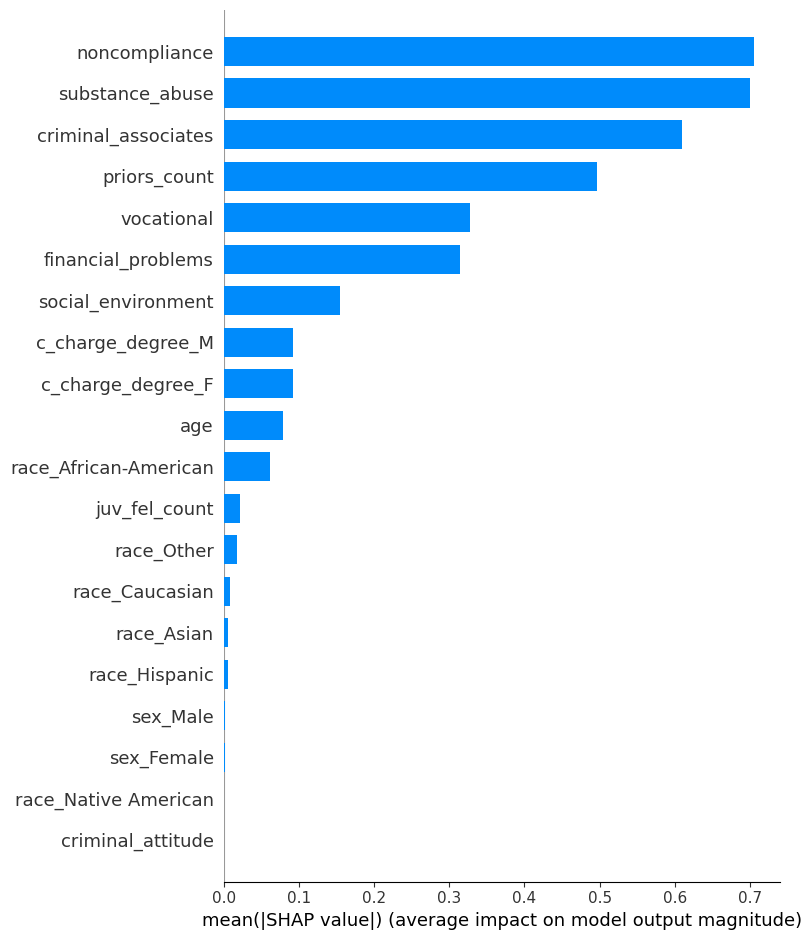

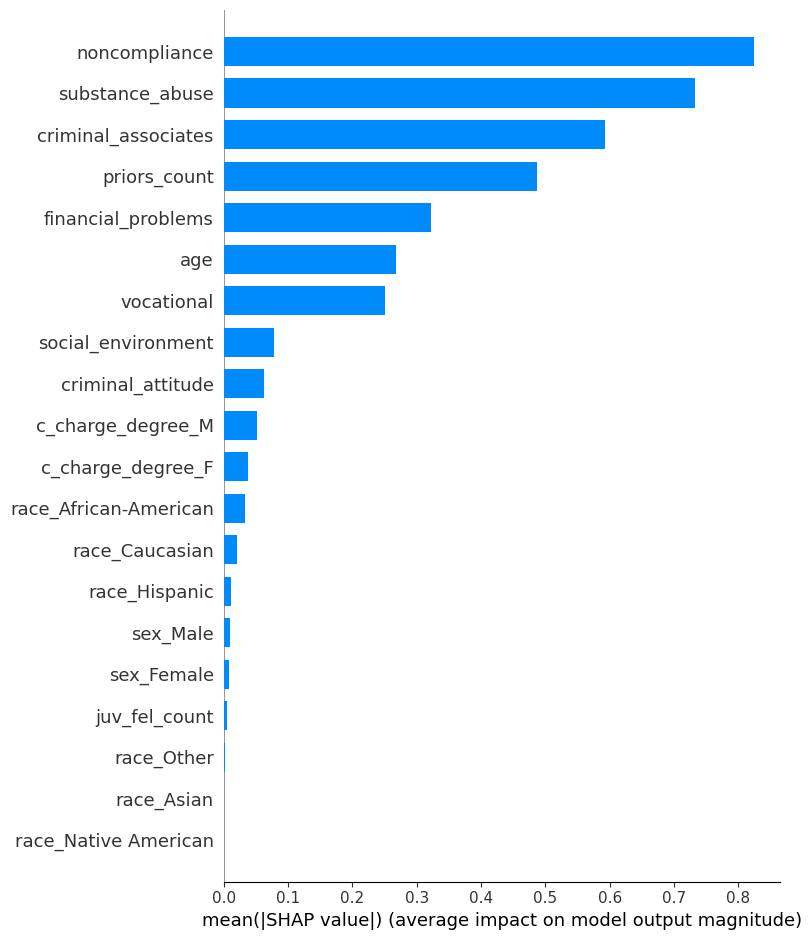

In [39]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Load the dataset
file_path = 'compas_synthetic_2024.csv'
compas_data = pd.read_csv(file_path)

# Identify categorical and numerical columns
categorical_cols = ['sex', 'race', 'c_charge_degree']
numerical_cols_corrected = [
    'age', 'priors_count', 'juv_fel_count', 'criminal_attitude', 
    'criminal_associates', 'financial_problems', 'substance_abuse',
    'noncompliance', 'social_environment', 'vocational'
]

# Define the column transformer with the corrected list
preprocessor_corrected = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols_corrected),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Split the dataset
X = compas_data.drop(['id', 'name', 'decile_score', 'risk_level', 'is_recid', 'two_year_recid', 'high_risk'], axis=1)
y = compas_data['decile_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing with the corrected configuration
X_train_prepared_corrected = preprocessor_corrected.fit_transform(X_train)
X_test_prepared_corrected = preprocessor_corrected.transform(X_test)

# Combine the names of the numerical columns with the generated categorical feature names
cat_feature_names = preprocessor_corrected.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols_corrected + list(cat_feature_names)

# Convert the transformed training and testing sets back into DataFrames
X_train_prepared_corrected_df = pd.DataFrame(X_train_prepared_corrected, columns=all_feature_names, index=X_train.index)
X_test_prepared_corrected_df = pd.DataFrame(X_test_prepared_corrected, columns=all_feature_names, index=X_test.index)

# Fit the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_prepared_corrected_df, y_train)

# SHAP Analysis for Linear Regression Model
linear_explainer = shap.Explainer(linear_model, X_train_prepared_corrected_df)
linear_shap_values = linear_explainer(X_train_prepared_corrected_df)

# Visualizing the impact of features on model output for Linear Regression
shap.summary_plot(linear_shap_values, X_train_prepared_corrected_df, feature_names=all_feature_names, plot_type="bar")

# Fit the Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_prepared_corrected_df, y_train)

# SHAP Analysis for Decision Tree Model
tree_explainer = shap.Explainer(tree_model, X_train_prepared_corrected_df)
tree_shap_values = tree_explainer(X_train_prepared_corrected_df)

# Visualizing the impact of features on model output for Decision Tree
shap.summary_plot(tree_shap_values, X_train_prepared_corrected_df, feature_names=all_feature_names, plot_type="bar")


## Shap Analysis of Scores including Synthetic Data  

The provided SHAP summary bar plots represent the average impact of each feature on the model's output for the Linear Regression and Decision Tree models, respectively. Each bar shows the mean absolute SHAP value for a feature across the dataset. A longer bar means a larger average impact on the model's predictions.  

### Linear Regression Model (First Image)  
For the Linear Regression model, the features with the greatest average impact on the model's predictions are:  

Noncompliance: Having the highest mean SHAP value, suggests that instances of noncompliance with prior court orders or conditions of supervision are strongly associated with higher COMPAS scores.  

Substance Abuse: This feature's large impact indicates that a history of substance abuse is considered a significant risk factor for recidivism.  

Criminal Associates: Indicates the model's emphasis on the influence of an individual's social connections on their risk of reoffending.  

Priors Count: The number of prior offenses also significantly impacts the model's output, with more prior offenses contributing to a higher risk score.  

The plot also indicates that demographic factors like age and race (African-American) have a notable impact on the COMPAS score predictions, which raises concerns about potential biases and fairness in the model.  

### Decision Tree Model (Second Image)  
For the Decision Tree model, the SHAP values demonstrate the following feature impacts:  

Noncompliance: Similar to the Linear Regression model, noncompliance is a major factor, suggesting the Decision Tree also views this as a critical predictor of recidivism.  
 
Substance Abuse: Consistent with the Linear Regression model, substance abuse is a key feature, reinforcing its perceived importance in assessing recidivism risk.  

Criminal Associates: Remains an important factor, showing that the individual's social network is considered relevant in both models.  

Priors Count: Continues to be an impactful variable, emphasizing the weight given to an individual's criminal history.  

Both models agree on the importance of these features, although the exact order and magnitude of impact may vary slightly. This consistency across models strengthens the case for case managers to focus on these areas when developing interventions.  

### Implications for Case Managers  
From these SHAP analyses, case managers can derive actionable insights:  

Addressing Noncompliance:   
Ensuring clients comply with court orders and supervision conditions could significantly reduce their predicted risk of recidivism.    
Substance Abuse Interventions:   
Providing access to substance abuse treatment programs could help mitigate this risk factor.   
Social Network Assessment:   
Working with clients to evaluate and potentially improve their social environments and associations could be beneficial.  

These insights can help case managers prioritize resources and interventions, focusing on the factors most likely to reduce COMPAS scores and, by extension, potentially lower the actual risk of recidivism. It is crucial to approach the use of COMPAS scores critically, recognizing the need for holistic and fair assessment methods that account for individual circumstances and systemic biases.   

## Explaining COMPAS to a Judge

For this portion of the presentation for the judge, I will explore the Partial Depence Plot exaplainability tool offered by the 'sklearn.inspection" library and the prior use of Shap values will be rehashed and summarized for a judicial perspective.  

The COMPAS algorithm is a risk assessment tool designed to aid judges in making decisions about bail by predicting the likelihood of a defendant reoffending (recidivism). Based on the SHAP value plots for Linear Regression and Decision Tree models, we can interpret the following:  

Noncompliance: This factor has the most significant impact on the predicted recidivism risk. It implies that individuals with a history of noncompliance with court orders or conditions of supervision are more likely to be predicted as higher risks.  

Substance Abuse: This feature's impact suggests that a history of substance abuse is associated with a higher risk of reoffending.  

Criminal Associates: A high influence of this factor indicates that the model gives weight to the individual's social network in predicting recidivism.  

Priors Count: The number of prior offenses also affects the prediction substantially, with more priors indicating a higher risk.  

Charge Degree: The severity of the current charge (misdemeanor vs. felony) also plays a role in determining risk.  

These features, particularly those related to past behavior and current charges, are relevant to a judge's decision-making process regarding bail. However, the use of such a tool for sentencing or plea bargaining raises several concerns:  

Consistency and Fairness: The algorithm's reliance on factors like race and sex may introduce or perpetuate biases, potentially affecting the fairness of sentencing and plea bargaining decisions. Judges would have to pay attention to these attributes and adjust their rulings accordingly.
  
Transparency: If the inner workings of the algorithm are not fully transparent, it may be challenging for those affected by its predictions to understand or contest those decisions.  This is another point for the case managers. 

Contextual Sensitivity: The algorithm may not adequately account for the nuances and individual circumstances of each case that a judge might consider during sentencing or plea bargaining.  

Given these considerations, while COMPAS could provide useful insights for bail decisions, relying on it for sentencing or plea bargaining without careful consideration of its potential biases and limitations might not be appropriate.  

The synthetic variables were made to be strongly influencing, but the argument about COMPAS is that it is baised against certain groups in part because of selective policing that leads to over-policing due to a feedback loop with higher decile_score figures.  

## Partial Dependence Plot Analysis

What does a PDP analysis of the priors_count show? A Partial Dependence Plot (PDP) is used in machine learning to show the effect of a single feature on the predicted outcome of a model, averaged over the distribution of all other features. It provides a graphical depiction of the marginal effect one or two features have on the predicted outcome of a model. PDPs can show whether the relationship between the target and a feature is linear, monotonic, or more complex.  

In the context of COMPAS and recidivism prediction, a PDP for the 'priors_count' variable, for example, would illustrate how changes in the number of prior convictions are associated with changes in the predicted recidivism risk, while averaging out the effects of all other features. It allows us to see whether having more prior convictions generally increases or decreases the predicted risk of recidivism, as assessed by the model, and how strong this relationship is.  

Since we are assuming the predictions have been made using a model that we don't have direct access to, but we have the linear_model and tree_model predictions and the corresponding features, we can create a PDP for the original COMPAS numerical features as follows:  

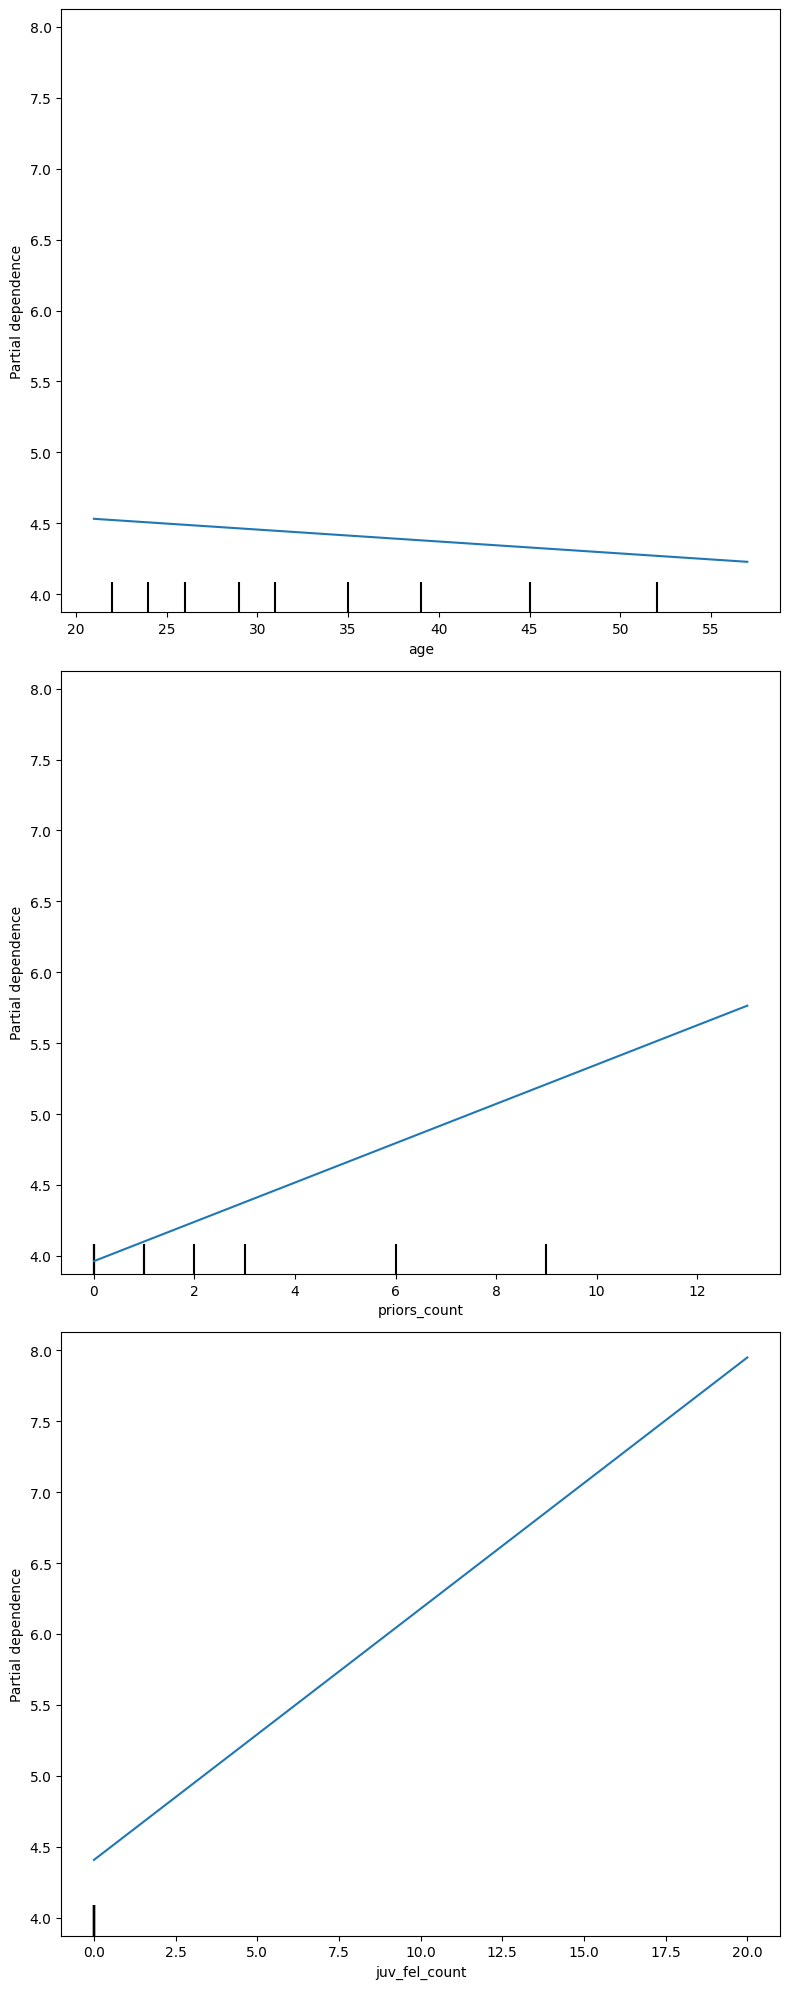

In [44]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Instantiate the Linear Regression model
linear_model = LinearRegression()

# Define preprocessing for numerical columns
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_pipeline = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_corrected),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Create the pipeline for Linear Regression
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline_linear.fit(X_train, y_train)

# Features for which to generate PDPs
features_to_plot = ['age', 'priors_count', 'juv_fel_count']

# Generate PDPs for multiple features using the Linear Regression pipeline
fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(8, 20))
PartialDependenceDisplay.from_estimator(
    pipeline_linear,
    X_train,
    features=features_to_plot,
    ax=ax,
    grid_resolution=20,
    n_cols=1  # Adjust as necessary for layout
)
plt.tight_layout()
plt.show()




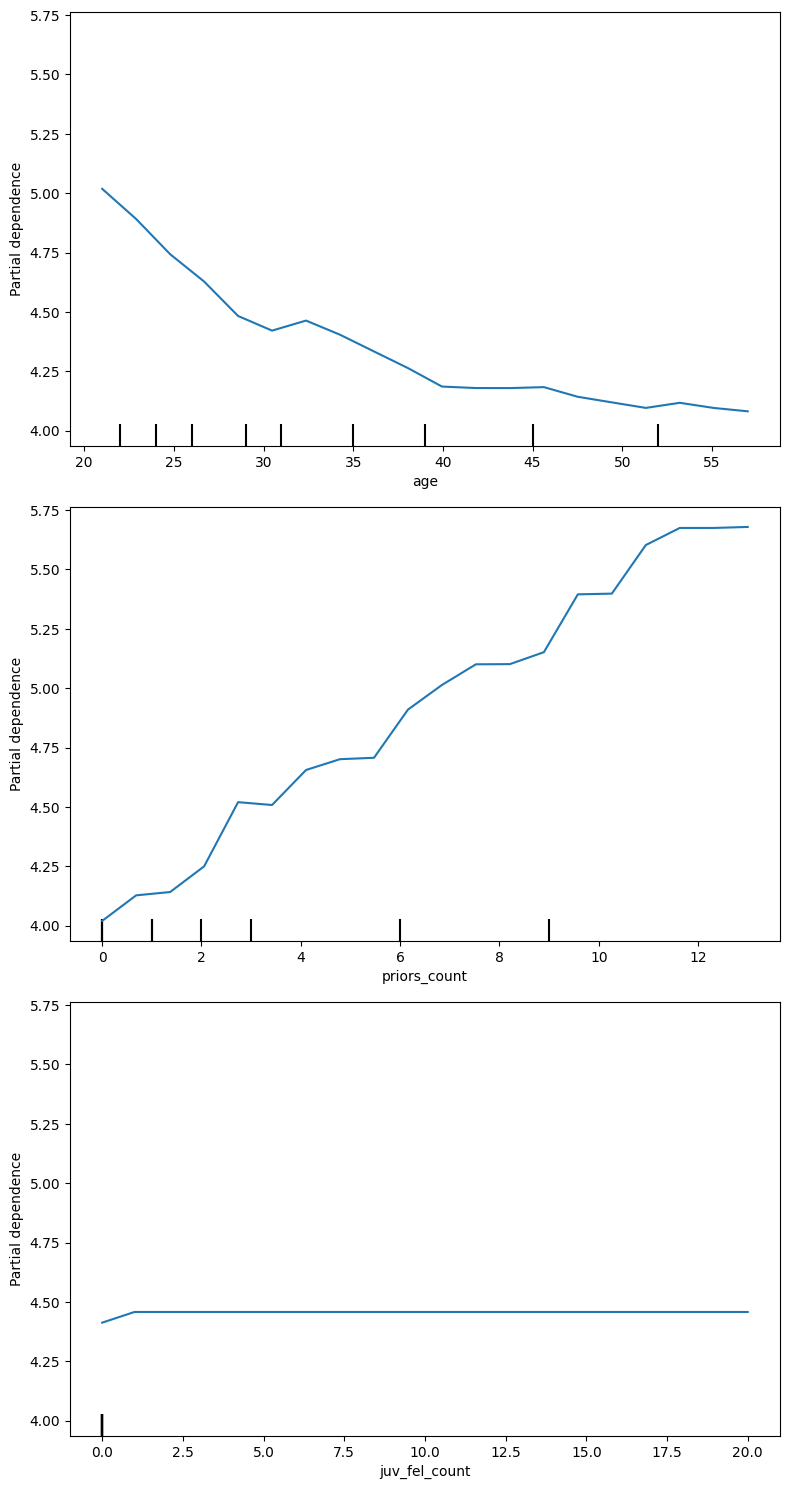

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming the 'preprocessor' is defined as above

# Create the pipeline for Decision Tree
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Fit the model
pipeline_tree.fit(X_train, y_train)

# Only numerical features for PDP
numerical_features_to_plot = ['age', 'priors_count', 'juv_fel_count']

# Generate PDPs for multiple numerical features using the Decision Tree pipeline
fig, ax = plt.subplots(len(numerical_features_to_plot), figsize=(8, len(numerical_features_to_plot) * 5))
PartialDependenceDisplay.from_estimator(
    pipeline_tree,
    X_train,
    features=numerical_features_to_plot,
    ax=ax,
    grid_resolution=20,
    kind='average'  # For sklearn version 0.24 and later, specify kind of plot
)
plt.tight_layout()
plt.show()



## Explanation of PDP Plots for the Original COMPAS Data

The Partial Dependence Plots (PDPs) show the relationships between a few individual features ('age', 'priors_count', 'juv_fel_count') and the target variable, as modeled by a Linear Regression model and a Decision Tree model. Here's an analysis of each:    

### Linear Regression Model Analysis:    
- **Age**: The PDP for 'age' indicates a relatively flat line, suggesting that age has little to no effect on the predicted outcome according to the linear model.  
- **Priors Count**: There is a clear positive relationship between the number of prior convictions ('priors_count') and the predicted outcome. As the number of prior convictions increases, so does the model's prediction, suggesting that this feature is an important predictor in the model.  
- **Juv Fel Count**: Similarly to 'priors_count', the 'juv_fel_count' also shows a positive relationship with the predicted outcome, indicating that juvenile felony counts are considered by the model when predicting the outcome.  
  
### Decision Tree Model Analysis:  
- **Age**: The PDP for 'age' with the Decision Tree model shows a decreasing trend. The predicted outcome decreases as age increases, which could suggest that the model is capturing a non-linear effect of age on the target variable.  
- **Priors Count**: The PDP shows a more complex, non-linear relationship. The predicted outcome increases with the number of prior convictions, but there are steps or thresholds, which is characteristic of decision tree behavior where decisions are made based on cutoff points in the feature space.  
- **Juv Fel Count**: The plot is mostly flat, indicating that within the range of most data points, 'juv_fel_count' doesn't have a strong effect on predictions. However, since it's a decision tree, there could be thresholds not captured in the range shown.  

### Differences Between the Models:  
- The Linear Regression model assumes a linear relationship between the features and the target, which is why the PDPs show straight lines. This model does not capture any non-linearities or interactions between features.  
- The Decision Tree model, on the other hand, is capable of capturing non-linearities and interactions, which is why its PDPs show steps and thresholds. The model makes decisions at certain points in the feature space, which leads to the piecewise constant plots we see.  
    
### Note on Comparison to COMPAS Model:  
It's important to note that the models analyzed here are not the COMPAS model itself. The COMPAS algorithm is a proprietary risk assessment tool that may use a different set of features, a different modeling approach, or possibly both. The PDPs from COMPAS would potentially look different and might reflect the proprietary considerations and methodology used in that model. The COMPAS model may also include features not present in the dataset used for these models, and it may use more complex modeling techniques to make predictions.  

Moreover, the COMPAS model may have been trained on different data, which would affect its predictions and the interpretation of its Partial Dependence Plots. The COMPAS algorithm could also potentially consider other interactions and nonlinear relationships that are not captured by the simpler models we have here.  

### Analysis and Implications:  

- **Model Limitations**: The simplicity of the Linear Regression model may not adequately capture complex patterns in data, which could lead to underfitting. Decision trees can capture more complex patterns but might overfit to the training data if not properly tuned or if not using ensemble methods like Random Forests or Gradient Boosted Trees.  

- **Model Interpretability**: Linear Regression models are generally easier to interpret because they provide direct coefficients for each feature, indicating the expected change in the outcome for a one-unit change in the feature. Decision Trees provide an intuitive understanding of how decisions are made based on feature values, but their interpretability decreases as the tree grows in depth and complexity.  

- **Use in Decision Making**: If these models were to be used in a decision-making context similar to the COMPAS system (which they should not without further validation and ethical review), the PDPs can offer some insight into what features are influencing the models' predictions the most. However, one must be cautious as these models' predictions and their PDPs could be very different from the actual COMPAS model's behavior.  

- **Ethical Considerations**: When algorithms are used in judicial settings, such as predicting recidivism, it's crucial to consider fairness, transparency, and accountability. Models must be scrutinized for potential biases, and stakeholders should have the ability to understand and challenge the predictions made about them.  

In summary, the PDPs for these two models provide a visual representation of how each feature influences the model's predictions on average, assuming all other features are held constant. However, for complex decision-making tools like the COMPAS system, more sophisticated models and thorough ethical, legal, and social examinations are essential before deployment.  Let's take a look at the PDP plots for the synthetic data and compare.

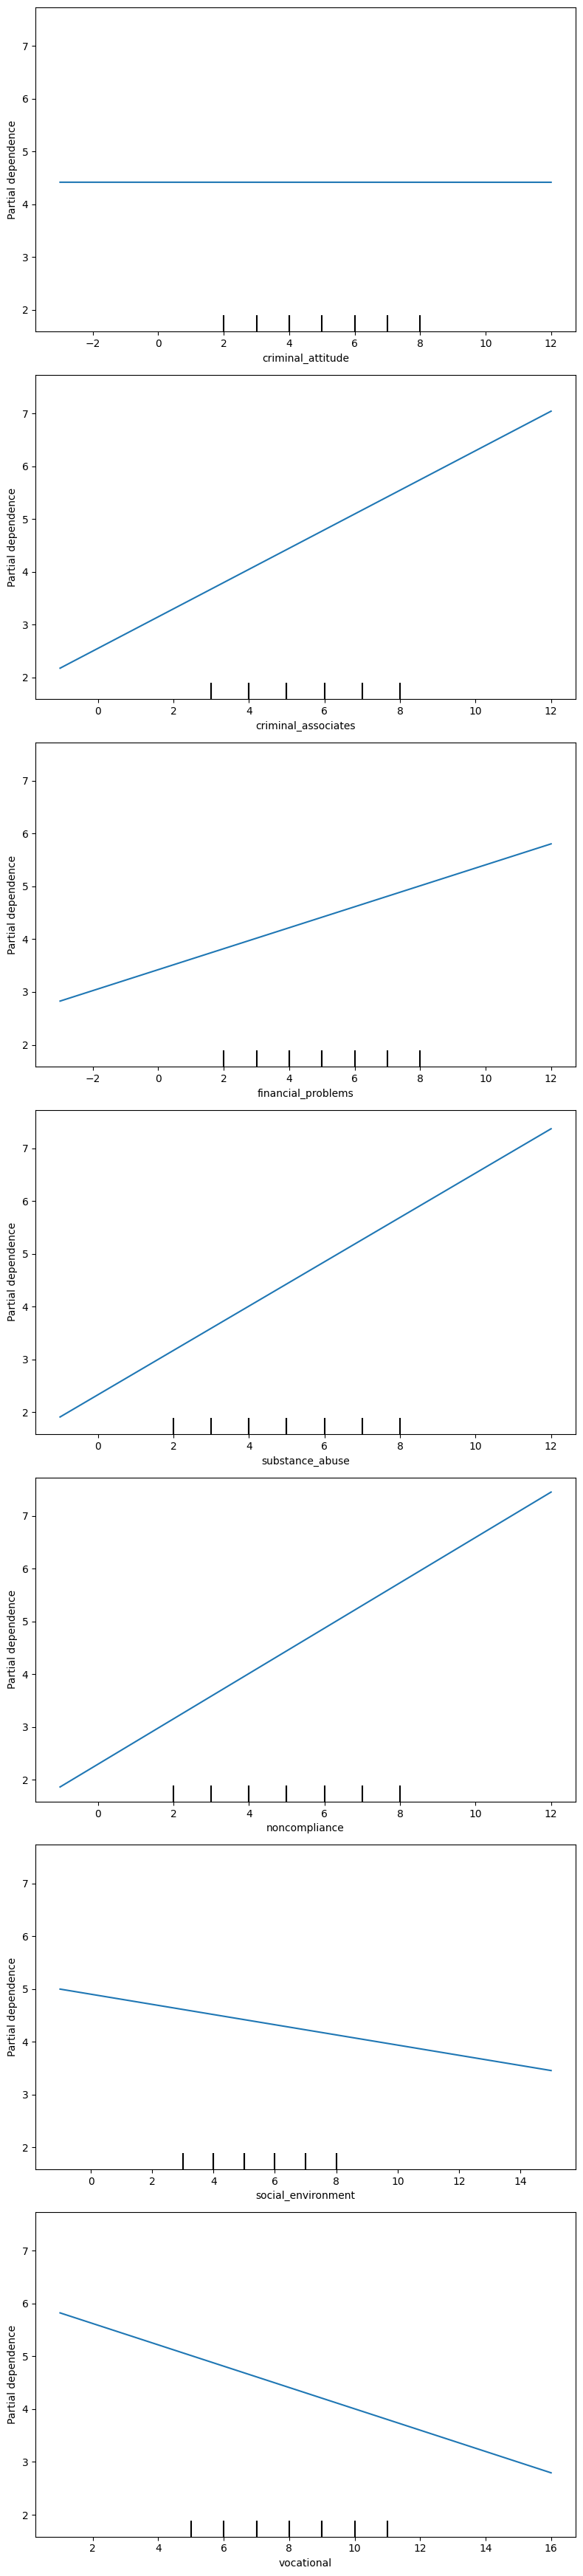

In [46]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Specified numerical features for PDP
numerical_features_to_plot = [
    'criminal_attitude', 
    'criminal_associates', 
    'financial_problems', 
    'substance_abuse',
    'noncompliance', 
    'social_environment', 
    'vocational'
]

# Generate PDPs for specified numerical features using the Linear Regression pipeline
fig, axs = plt.subplots(len(numerical_features_to_plot), figsize=(8, len(numerical_features_to_plot) * 5))
PartialDependenceDisplay.from_estimator(
    pipeline_linear,
    X_train,
    features=numerical_features_to_plot,
    ax=axs,
    grid_resolution=20,
    kind='average'
)
plt.tight_layout()
plt.show()


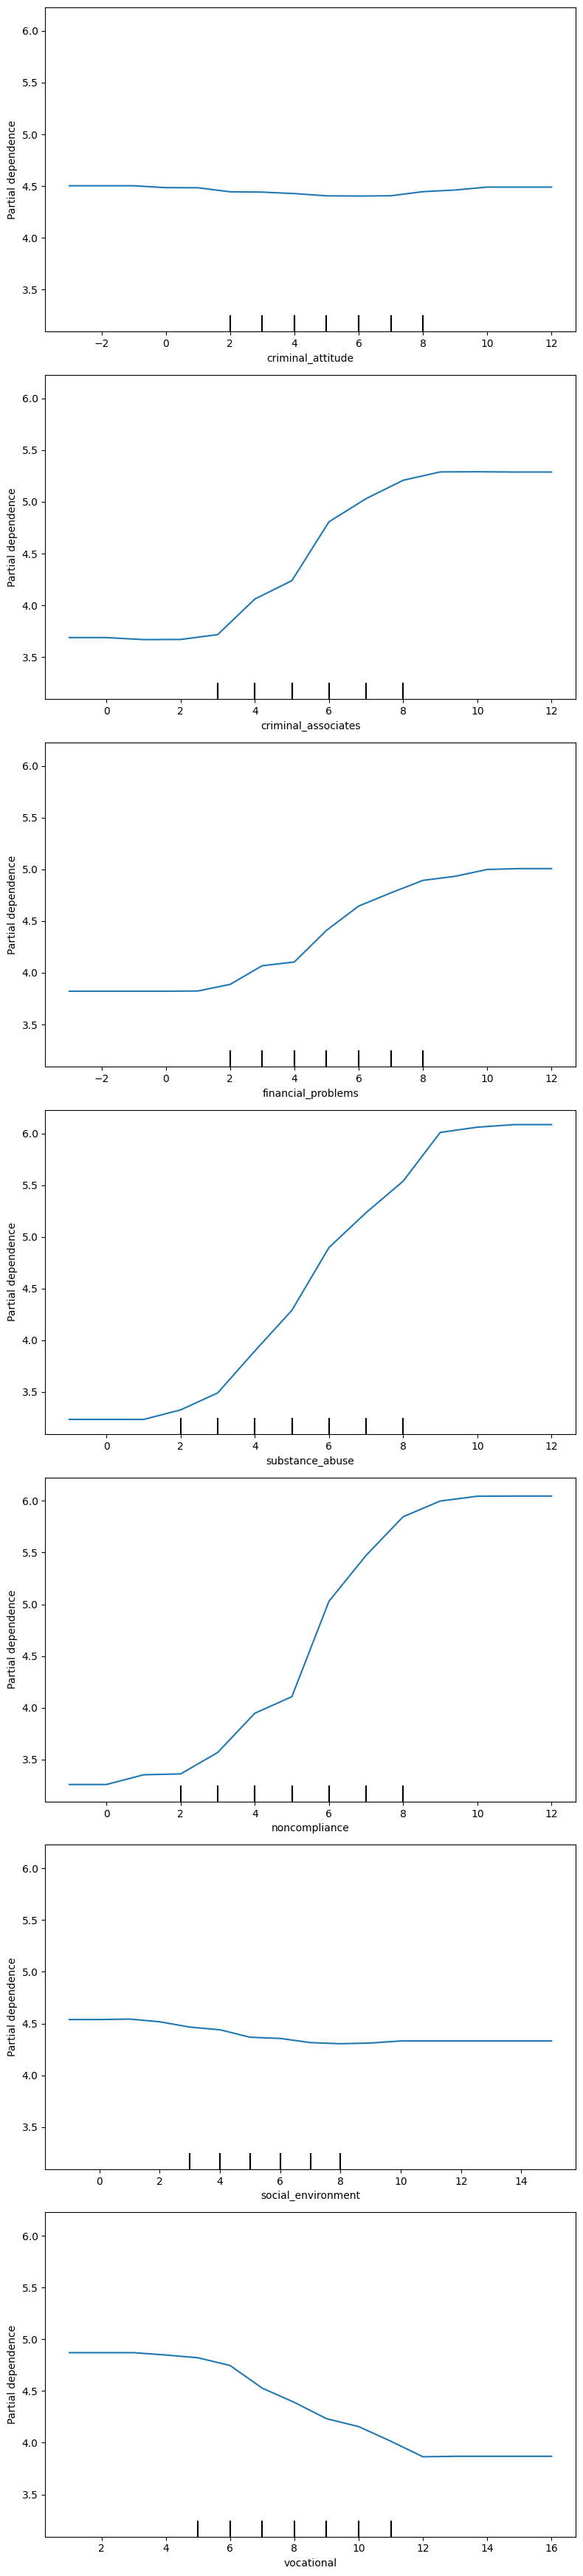

In [47]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Specified numerical features for PDP
numerical_features_to_plot = [
    'criminal_attitude', 
    'criminal_associates', 
    'financial_problems', 
    'substance_abuse',
    'noncompliance', 
    'social_environment', 
    'vocational'
]

# Generate PDPs for specified numerical features using the Decision Tree pipeline
fig, axs = plt.subplots(len(numerical_features_to_plot), figsize=(8, len(numerical_features_to_plot) * 5))
PartialDependenceDisplay.from_estimator(
    pipeline_tree,
    X_train,
    features=numerical_features_to_plot,
    ax=axs,
    grid_resolution=20,
    kind='average'
)
plt.tight_layout()
plt.show()


## PDP Results for Synthetic Data

Based on the Partial Dependence Plots (PDPs) for the synthetic data with both models, we can draw several conclusions about the behavior of the features in relation to the predicted outcome. Here is the analysis for each model, followed by a comparison and a summary for judicial understanding:

### Analysis of Linear Regression Model:
- **Criminal Attitude**: The PDP is quite flat, indicating that the criminal attitude feature has little to no impact on the model's predictions. This suggests that, within the observed data range, changes in criminal attitude do not significantly alter the risk score assigned by the linear model.
- **Other Features**: The remaining features (criminal associates, financial problems, substance abuse, noncompliance, social environment, vocational) all display a positive relationship with the predicted outcome, which suggests that increases in these factors are associated with higher risk scores as determined by the linear model.

### Analysis of Decision Tree Model:
- **Criminal Attitude**: Similar to the linear model, the criminal attitude feature has a very flat PDP, indicating a lack of influence on the predictions from the decision tree model as well.
- **Other Features**: The PDPs for the decision tree model show a more varied response compared to the linear model. Some features show a more pronounced step-like effect, characteristic of decision trees. For instance, substance abuse and financial problems display a non-linear relationship with the risk score, with certain thresholds at which the risk score increases.

### Comparison of the Two Analyses:
- The flatness of the criminal attitude feature's PDP in both models indicates that it might not be a significant predictor in the context of these specific models or within the range of data provided.
- The linear model suggests a more uniform, gradual increase in risk score with the synthetic features, which aligns with the assumption of linear relationships.
- The decision tree model captures non-linear effects and interactions, resulting in steps and thresholds in the PDPs. This could mean that the decision tree is more sensitive to certain values or combinations of values within the synthetic features.

### Summary for a Judge:
- **Model Interpretation**: The linear model implies that risk score increases uniformly with most synthetic features, while the decision tree suggests more complex relationships with certain thresholds that could drastically change the risk score.
- **Criminal Attitude**: The lack of influence of criminal attitude in both models indicates that it may not be a key factor in determining recidivism risk, at least within the range of the observed data. This could be due to a lack of variation in this feature across the dataset or it being less predictive than other features.
- **Implications**: When considering such models to assist with judicial decisions, it is crucial to understand how each feature affects the prediction. A model that overly simplifies complex human behavior, like the linear model, may not capture the true nuances of risk. Conversely, a model that is too sensitive to certain data points, like the decision tree, could lead to inconsistent outcomes.
- **Decision Support**: These models should be used as support tools, not determinants, in decision-making processes. It is essential to integrate comprehensive, individual assessments and consider the broader context beyond what the model can provide.

In conclusion, the PDPs illustrate that while some features consistently influence the predicted risk scores, others may not be as influential, and the impact varies between the linear and decision tree models. For a judge, this information underscores the importance of a cautious and informed approach when using algorithmic predictions, ensuring that they complement, rather than replace, human judgment and legal expertise.